In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import warnings

import sklearn
from sklearn.model_selection import train_test_split,GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV

from sklearn import metrics
from sklearn.linear_model.coordinate_descent import ConvergenceWarning

In [2]:
## 设置字符集，防止中文乱码
mpl.rcParams['font.sans-serif']=[u'simHei']
mpl.rcParams['axes.unicode_minus']=False
## 拦截异常
warnings.filterwarnings(action = 'ignore', category=ConvergenceWarning)

##### 1、数据加载

In [3]:
names = ['CRIM','ZN', 'INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','Target']   # 从网上获得，共13个参数
path = "datas/boston_housing.data"

fd = pd.read_csv(path,header=None)   # 原文件中不包含header，使用header=None空出header
fd.head()

# 此处没有直接用sep来分割的原因是由于文件中存在较多空格，并包含NaN（非 ?），所以具体数据列表的划分放在后面单独处理

,0
0,0.00632 18.00 2.310 0 0.5380 6.5750 65...
1,0.02731 0.00 7.070 0 0.4690 6.4210 78...
2,0.02729 0.00 7.070 0 0.4690 7.1850 61...
3,0.03237 0.00 2.180 0 0.4580 6.9980 45...
4,0.06905 0.00 2.180 0 0.4580 7.1470 54...


##### 1.1 数据处理
—— enumerate() 生成一列索引，常用于for循环中，由i,d进行接收，i为元素序号，d为样本矩阵

—— map(函数f，序列l) 通过把函数f 依次作用在 序列l 的每个元素上，返回新的 序列。是一种映射，返回列数类型是map，通常需要转list

—— filter(函数，序列) 过滤掉不符合条件的元素，返回由符合条件元素组成的新列表：序列的每个元素作为参数传递给函数进行判断，将返回 True 的元素放到新列表中

In [6]:
data = np.empty((len(fd), 14))   # 创建一个空narray数列（N*13），用来接收数据。行数按照fd样本数来建立，以获得充足的样本空间

def notEmpty(s):
    if s != '':
        return s  # 返回非空数据

for i, d in enumerate(fd.values):
    d = map(float, filter(notEmpty, d[0].split(' ')))   # 过滤掉空值
    data[i] = list(d)   # 将map数据转list，并为建立新的数据表data做准备

##### 2 数据划分 + 数据分割

In [7]:
data = pd.DataFrame(data,columns=names)
x = data[names[0:13]]   # 方法二:x, y = np.split(data, (13, ), axis=1)   # 按行遍历，把前13个参数给x，把剩余部分（最后一列参数）给y
y = data[names[13]]
m,n = np.shape(x)

print ("样本数据量:%d, 特征个数：%d" % (m,n))

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

样本数据量:506, 特征个数：13


##### 3、管道准备 和 参数字典
设定参数字典，字典中的key是属性的名称，value是可选的参数列表，通过GridSearchCV选出最优参数value

In [8]:
models = [
    Pipeline([
            ('ss', StandardScaler()),   # 当管道中存在预处理模型的时候，管道被使用时会自动调用预处理模型。
            ('poly', PolynomialFeatures()),
            ('linear', RidgeCV(alphas=np.logspace(-3,1,20)))   # 可以在管道中先行设定参数
        ]),
    Pipeline([
            ('ss', StandardScaler()),
            ('poly', PolynomialFeatures()),
            ('linear', LassoCV(alphas=np.logspace(-3,1,20)))
        ])
] 

# 预设阶数：前三个是PolynomialFeatures()多项式的属性，后一个是RidgeCV和LassoCV回归算法的属性
parameters = {
    'poly__degree': [3,2,1],
    'poly__interaction_only': [True, False],   # 是否存在交叉项，由特征自己和自己结合的项产生，如X1^2 和 X2^2，默认为False
    'poly__include_bias': [True, False],   # 默认为True，表示存在多项式幂为零的特征，并将该特征作为线性模型的截距（偏置项）
    'linear__fit_intercept': [True, False]   # 默认为True，表示训练模型需要加一个截距项；若参数为False时，表示模型无需加截距项
}

##### 4、x轴数据压缩 + 数据预处理 + 模型构建（CV） + 训练 + 预测 + 模型评估 + 绘图
①、管道功能包含：模型参数设定 + 数据预处理 + 模型构建   ★★★

②、GrideSearchCV功能包含：引入算法 / 管道，对管道中的参数依次进行验证，以确定最优参数

—— GridSearchCV(模型，...) 进行交叉验证，选择出最优的参数值出来

    -》param_grid：可选参数列表，要求是字典类型   ★
    -》cv: 进行N折交叉验证。将训练集分成N份，N-1份用来训练，最后1份用来验证，并循环。
    -》n_jobs：CPU占用量
    
#交叉验证的常用属性

—— model.best_params＿：返回最佳结果的参数组合

—— model.best_score＿：计算最佳参数状态下的准确率R^2

—— model.best_estimator＿  获取最佳模型

—— model.grid_scores＿：返回不同参数情况下的评价结果

Ridge算法:最优参数:{'linear__fit_intercept': True, 'poly__degree': 2, 'poly__include_bias': False, 'poly__interaction_only': True}
Ridge算法:$R^2$=0.874
Lasso算法:最优参数:{'linear__fit_intercept': False, 'poly__degree': 3, 'poly__include_bias': True, 'poly__interaction_only': True}
Lasso算法:$R^2$=0.857


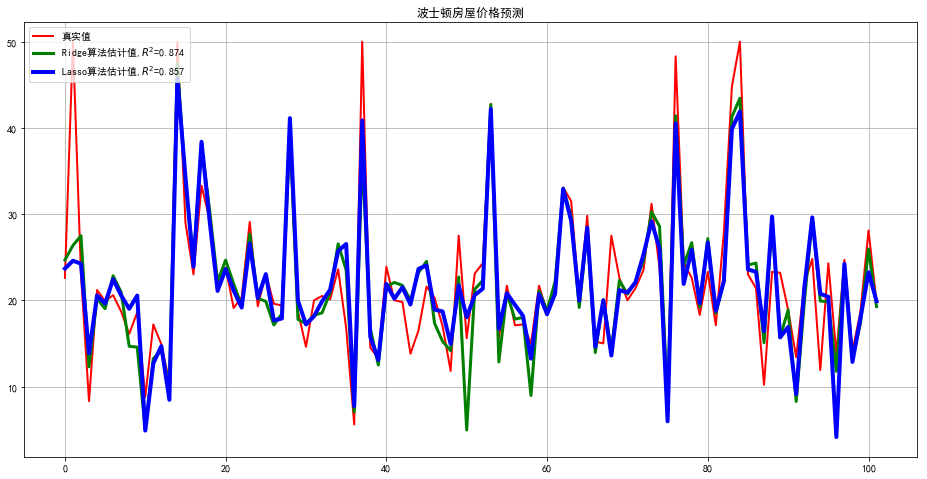

In [9]:
titles = ['Ridge', 'Lasso']  # LassoCV和RidgeCV模型比较运行图表展示
colors = ['g-', 'b-']
plt.figure(figsize=(16,8))

ln_x_test = range(len(x_test))   # x轴数据压缩
plt.plot(ln_x_test, y_test, 'r-', lw=2, label='真实值')

for t in range(2):   # 多管道情况下，用for遍历算法类型
    model = GridSearchCV(models[t], param_grid=parameters,cv=5)  # 1、五折交叉验证
    # model.set_params(Poly__degree=d) 以及 fit_transform 等 一系列的操作都由 param_grid=parameters 来完成了   ★★★
    
    model.fit(x_train, y_train)   # 2、模型训练
    y_predict = model.predict(x_test)   # 3、模型预测
    
    print ("%s算法:最优参数:%s" % (titles[t],model.best_params_))    # 4、获取最优解
    print ("%s算法:$R^2$=%.3f" % (titles[t],model.best_score_))    # 模型评估
    
    plt.plot(ln_x_test, y_predict, colors[t], lw = t + 3, label='%s算法估计值,$R^2$=%.3f' % (titles[t],model.best_score_))   # 绘制测试图形
    
plt.legend(loc = 'upper left')
plt.grid(True)
plt.title(u"波士顿房屋价格预测")
plt.show()

### 一阶Lasso模型

In [19]:
model = [
    Pipeline([
            ('ss', StandardScaler()),
            ('poly', PolynomialFeatures(degree=1, include_bias=True, interaction_only=True)),
            ('linear', LassoCV(alphas=np.logspace(-3,1,20), fit_intercept=False))
        ])
    ]

model[0].fit(x_train, y_train)

print ("theta参数:", list(zip(names,model[0].get_params('linear')['linear'].coef_)))   # —— list(zip( a,b )) 参数列表
print ("截距:", model[0].get_params('linear')['linear'].intercept_)

theta参数: [('CRIM', 22.600592809201991), ('ZN', -0.93534557687414599), ('INDUS', 1.0202352850146847), ('CHAS', -0.0), ('NOX', 0.59483138415461523), ('RM', -1.8002644875942371), ('AGE', 2.5861907995357285), ('DIS', -0.064956108249541261), ('RAD', -2.8017533936656509), ('TAX', 1.9343329692037579), ('PTRATIO', -1.7218677875512216), ('B', -2.2762334623842988), ('LSTAT', 0.70288003005515409), ('Target', -3.599196562418312)]
截距: 0.0


L1-norm通过Lasso模型训练后，有的参数可能出现为0的或者接近0的情况； 针对于这一批的特征，可以进行特征的删除操作 df.drop(xx)，实际工作中，一般情况下，除非低于10^-6才会删除

自己实现参数值绝对值小于10^-6的所有特征属性删除；要求：不允许明确给定到底删除那一个特征属性，不能写成df.drop(['CHAS', 'DIS'])